#  <center>Tweet Sentiment Classification <br> <small> Martin Sejas
About the dataset:

List of tweet texts with emotion labels like joy, sadness, fear, anger...
Dataset is split into train, test and validation sets for building the machine learning model. At first, you are
given only train and test sets. The validation one will be given in the end of the project for you to check
the final performance of your algorithm (to make sure there is no overfitting over the test data).
You can work on this project on group of one, two or three students. This exercise is mandatory, not
giving it back is equivalent to getting to lowest grade.
Goal:

• Train different kind of models able to classify each text according to the sentiment mainly present
in it

• Compare the results of your different models and try to analyze and explain the differences

Train different classification models relying mainly on

1. A Fully Connected Neural Network (see Course 2) 5 points

2. A Recurrent Neural Network, based on LSTM or GRU (see Course 3) 5 points

3. A fine-tuned Transformer Architecture from a pretrained model that can be found on sites
like HuggingFace (see Course 4) 5 points

4. Compare the different models to find the best approach and try to duplicate it on a “real life”
text classification approach (this new “real life” dataset will be given to you soon) 5 points

# Loading and Preprocessing the data sets

In [ ]:
import math
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau


The dataset is a tweets sentiment dataset, it's quite straightforward, there are only 2 columns, the tweet itself, and the sentiment attached to it. We have been provided a train set and a test set.

In [ ]:
df_train = pd.read_csv('./train.txt', header=None, delimiter=';')
df_test = pd.read_csv('./test.txt', header=None, delimiter=';')
df_train = df_train.rename(columns={0: 'tweet', 1: 'sentiment'})
df_test = df_test.rename(columns={0: 'tweet', 1: 'sentiment'})
df_train.head()

,tweet,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


After loading our dataset we can see the class (sentiment) distribution of our tweets.

In [ ]:
df_train['sentiment'].value_counts(), df_train.shape

(joy         5362
 sadness     4666
 anger       2159
 fear        1937
 love        1304
 surprise     572
 Name: sentiment, dtype: int64,
 (16000, 2))

In [ ]:
df_test['sentiment'].value_counts(), df_test.shape

(joy         695
 sadness     581
 anger       275
 fear        224
 love        159
 surprise     66
 Name: sentiment, dtype: int64,
 (2000, 2))

We can see here that there are class inbalances. Especially regarding joy and surprise.

We will also separate each tweet from it's label to train.

In [ ]:
texts_train = df_train['tweet']
texts_test = df_test['tweet']

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(df_train['sentiment'])
y_test = le.transform(df_test['sentiment'])
y_train

array([4, 4, 0, ..., 2, 0, 4])

## Pre-Processing the tweets (Lemmetizing) with the Spacy library.

### Lemmetization

We are going to be using the famous [Spacy](https://spacy.io/) Library for tokenization, it's the best performing one in terms of computational cost and performance.

We will be loading the english core *medium* dataset.



To have spacy working please make sure to run the following commands.

```bash
pip install spacy
```

Once the package has been installed, make sure to download the language model, in our case, *en-core-web-md* will be used, and can be downloaded by the following command.

```bash
python -m spacy download en_core_web_md
```

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en_core_web_md

2023-07-20 14:55:34.552592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 17.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
nlp = spacy.load('en_core_web_md')

#Function to tokenize
def preprocess_text(text):
    #every tweet will become a document
    doc = nlp(text)

    #Creating a list of tokens by lemmatizing the words, filtering stop words.
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]

    #Join all the words in one sentence
    return ' '.join(tokens)

With the *preprocess_text* function, we will pre-process the tweet text, and with that we can apply it to both of our dataframes as a new series, and see the output.

*Warning this cell takes over 2 minutes to run!*

In [ ]:
df_train['processed'] = df_train['tweet'].apply(preprocess_text)
df_test['processed'] = df_test['tweet'].apply(preprocess_text)
df_train.head()

,tweet,sentiment,processed
0,i didnt feel humiliated,sadness,not feel humiliate
1,i can go from feeling so hopeless to so damned...,sadness,feel hopeless damn hopeful care awake
2,im grabbing a minute to post i feel greedy wrong,anger,m grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,feel nostalgic fireplace know property
4,i am feeling grouchy,anger,feel grouchy


## Task 1- Fully Connected Neural Network(5 Points)
### TF-IDF embedding for Sequential Neural Network


We will be using sklearn's TFidfVectorizer to be able to process the data and feed it into our Neural Network.

In [ ]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

dtm_train = tfidf.fit_transform(df_train['processed'])
dtm_test = tfidf.transform(df_test['processed'])
dtm_train.shape

(16000, 5587)

Split the training set to training and validation sets for training the model

In [ ]:
X_train_ = dtm_train.toarray()
X_test_ = dtm_test.toarray()
y_train_ = y_train
y_test_ = y_test
# X_train_ = np.vstack((X_train_, X_test_))
# y_train_ = np.concatenate((y_train, y_test))


class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)


# X_train_, X_test_, y_train, y_test_ = train_test_split(X_train_, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_, y_train, test_size=0.2, random_state=42, stratify=y_train)

Encode the label in one hot encoding fashion

In [ ]:
y_train_encoded = to_categorical(y_train_)
y_test_encoded = to_categorical(y_test_)
y_val_encoded = to_categorical(y_val_)
y_train_encoded.shape, y_test_encoded.shape, y_val_encoded.shape

((12800, 6), (2000, 6), (3200, 6))

# Fully connect NN

Build the fully connected NN with tensorflow.

The first layer has a high number of nerons because the input data set has `>5000` features.

In [ ]:
model = Sequential()
model.add(Dense(4096, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_train_.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(2048, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(1024, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
# model.add(Dense(512, activation='selu', kernel_initializer='lecun_normal', ))
# model.add(Dense(128, activation='selu', kernel_initializer='lecun_normal', ))
model.add(Dense(64, activation='selu',))
model.add(Dense(6, activation='softmax'))

model.layers[-1].bias.assign(class_weights)
model.compile(optimizer='Adam', loss=tf.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4096)              22888448  
                                                                 
 dense_6 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 64)                65600     
                                                                 
 dense_9 (Dense)             (None, 6)                 390       
                                                                 
Total params: 33,443,270
Trainable params: 33,443,270
Non-trainable params: 0
_________________________________________________________________


Set up the early stopping condition and use a dynamic learning rate scheduler

In [ ]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

lr_scheduler = LearningRateScheduler(step_decay)

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3) #

Training the model

In [ ]:
history = model.fit(X_train_, y_train_encoded, validation_data=(X_val_, y_val_encoded), epochs=20, batch_size=256, callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
50/50 [==============================] - 4s 37ms/step - loss: 37.1047 - accuracy: 0.6616 - val_loss: 2.2726 - val_accuracy: 0.7844 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 1s 29ms/step - loss: 1.4871 - accuracy: 0.8019 - val_loss: 1.3084 - val_accuracy: 0.7962 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 1s 28ms/step - loss: 1.2147 - accuracy: 0.8252 - val_loss: 1.2724 - val_accuracy: 0.7987 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 1s 26ms/step - loss: 1.0433 - accuracy: 0.8612 - val_loss: 1.0891 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 1s 25ms/step - loss: 0.9411 - accuracy: 0.8799 - val_loss: 1.0446 - val_accuracy: 0.8434 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 1s 22ms/step - loss: 0.8852 - accuracy: 0.8995 - val_loss: 1.1083 - val_accuracy: 0.8288 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 1s 23ms/step - loss: 0.

Plot the training loss

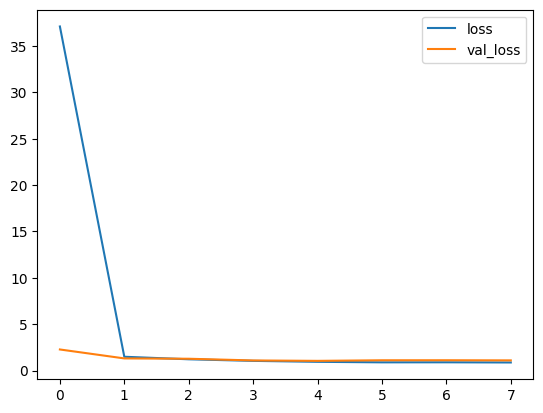

In [ ]:
loss, val_loss = history.history['loss'], history.history['val_loss']

plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

Test the model on test dataset

In [ ]:
predictions = model.predict(X_test_)
prediction_labels = predictions.argmax(axis=1)
print(classification_report(y_test, prediction_labels))
print(confusion_matrix(y_test_, prediction_labels))
print(accuracy_score(y_test_, prediction_labels))

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       275
           1       0.79      0.82      0.80       224
           2       0.86      0.89      0.88       695
           3       0.63      0.76      0.69       159
           4       0.92      0.83      0.87       581
           5       0.66      0.61      0.63        66

    accuracy                           0.84      2000
   macro avg       0.78      0.79      0.78      2000
weighted avg       0.84      0.84      0.84      2000

[[228  12  12   4  19   0]
 [  5 183  12   0   7  17]
 [  7   6 620  51  10   1]
 [  2   0  28 121   6   2]
 [ 25  23  39  13 480   1]
 [  1   9  11   3   2  40]]
0.836


I have tried several dozens of times on this model: increasing and reducing the layers, increasing and reducing the neurons in each layer, tuning the regularization parameter, changing regularization, tuning the learning rate, batch size, *etc*.

I also tried to experiment on the different input, using different representation of original text for model training, such as embedding with spacy. There were several different accuracy ceiling for my model from low to high with increasing the model complexity, `34%` to `56%`, and `86%`. And finally I got this result with the tf_idf matrix representation for training the model while the scale of the model is large with nearly 34 million. And the Accuracy on test was improved from `< 40%` to now `> 80%`.

With `> 80%` accuracy, I also run dozens of experimentation to improve the accuracy, however, it is very hard to get a better accuracy, in the meantime I am already overfitting with the training set. I tried to tackle the overfitting problem, but I will get lower accuracy. So I decided to keep this model setup.

Save the model, the folder of saved model is ignored for commit to github

In [ ]:
model.save('FNN_model')

# RNN, LSTM and GRU

In [ ]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show();

In [ ]:
df_train.head()

,tweet,sentiment,processed
0,i didnt feel humiliated,sadness,not feel humiliate
1,i can go from feeling so hopeless to so damned...,sadness,feel hopeless damn hopeful care awake
2,im grabbing a minute to post i feel greedy wrong,anger,m grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,feel nostalgic fireplace know property
4,i am feeling grouchy,anger,feel grouchy


In [ ]:
max_length = 100
trunc_type='post'


tokenizer = Tokenizer() #(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df_train['tweet'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df_train['tweet'])
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(df_test['tweet'])
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(df_train['sentiment'])
y_test = le.transform(df_test['sentiment'])
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = max_length


model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64)), #32
    Dropout(0.4),
    Dense(32, activation='leaky_relu', kernel_regularizer='l1_l2'),
    Dropout(0.4),
    Dense(6, activation='softmax')
])


loss_function = 'categorical_crossentropy'
optimizer = 'adam'

model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy', Precision(), Recall(), AUC()])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1521300   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 6)                 198       
                                                      

In [ ]:
predictors = np.array(padded)
label = np.array(y_train_encoded)
epochs_value = 50
validation_split_value = 0.2
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)

history = model.fit(predictors, label, epochs=epochs_value, verbose=1, validation_split=validation_split_value, callbacks=[early_stopping])

Epoch 1/50
400/400 [==============================] - 41s 89ms/step - loss: 2.4036 - accuracy: 0.3648 - precision: 0.6458 - recall: 0.0330 - auc: 0.7186 - val_loss: 1.5023 - val_accuracy: 0.5266 - val_precision: 0.7307 - val_recall: 0.1950 - val_auc: 0.7828
Epoch 2/50
400/400 [==============================] - 10s 25ms/step - loss: 1.3698 - accuracy: 0.5701 - precision: 0.8441 - recall: 0.2631 - auc: 0.8312 - val_loss: 1.2686 - val_accuracy: 0.5909 - val_precision: 0.8893 - val_recall: 0.2812 - val_auc: 0.8621
Epoch 3/50
400/400 [==============================] - 7s 18ms/step - loss: 1.2138 - accuracy: 0.6031 - precision: 0.8394 - recall: 0.3397 - auc: 0.8721 - val_loss: 1.2043 - val_accuracy: 0.5944 - val_precision: 0.8868 - val_recall: 0.2766 - val_auc: 0.8778
Epoch 4/50
400/400 [==============================] - 8s 19ms/step - loss: 1.0482 - accuracy: 0.6361 - precision: 0.8305 - recall: 0.5164 - auc: 0.9163 - val_loss: 0.9813 - val_accuracy: 0.7006 - val_precision: 0.8303 - val_rec

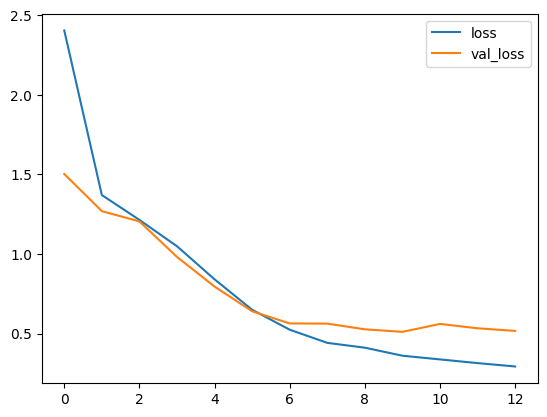

In [ ]:
loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(testing_padded)
prediction_labels = predictions.argmax(axis=1)
print(classification_report(y_test, prediction_labels))
print(confusion_matrix(y_test, prediction_labels))
print(accuracy_score(y_test, prediction_labels))

63/63 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       275
           1       0.85      0.93      0.89       224
           2       0.93      0.92      0.93       695
           3       0.76      0.84      0.80       159
           4       0.96      0.96      0.96       581
           5       0.63      0.55      0.59        66

    accuracy                           0.91      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.91      0.91      0.91      2000

[[239  14   3   1  16   2]
 [  4 208   1   1   4   6]
 [  3   1 642  36   3  10]
 [  1   0  21 134   1   2]
 [  6   4  11   2 557   1]
 [  2  17   9   2   0  36]]
0.908


# Transformer based Pretrained model

In [ ]:
texts_train = df_train['tweet']
texts_test = df_test['tweet']

df_train.head()

,tweet,sentiment,processed
0,i didnt feel humiliated,sadness,not feel humiliate
1,i can go from feeling so hopeless to so damned...,sadness,feel hopeless damn hopeful care awake
2,im grabbing a minute to post i feel greedy wrong,anger,m grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,feel nostalgic fireplace know property
4,i am feeling grouchy,anger,feel grouchy


- Importing Transformers

Fast Encode Function Retrieved From the internet.

In [ ]:
from tqdm import tqdm

def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.6 MB/s eta 0:00:00


In [ ]:
import transformers
from tokenizers import BertWordPieceTokenizer

#Loading bert tokenizer
bert_tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

#Saving it on our local folder
bert_tokenizer.save_pretrained('.')


#Loading a fast tokenizer
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

Creation of validation set

In [ ]:
bert_X_train, bert_X_valid, bert_Y_train, bert_Y_valid = train_test_split(df_train['tweet'].values, df_train['sentiment'].values,test_size=0.2,random_state=42,stratify=df_train['sentiment'])

Encoding raw test for training validation and test.

In [ ]:
X_train = fast_encode(bert_X_train, fast_tokenizer, maxlen=max_length)
X_valid = fast_encode(bert_X_valid, fast_tokenizer, maxlen=max_length)
X_test = fast_encode(df_test['tweet'].to_numpy(), fast_tokenizer, maxlen=max_length)

100%|██████████| 8/8 [00:00<00:00, 17.79it/s]


In [ ]:
X_train.shape

(12800, 100)

Encoding the labels.

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(bert_Y_train)
y_valid = le.transform(bert_Y_valid)
y_test = le.transform(df_test['sentiment'])
y_train_encoded = to_categorical(y_train)
y_valid_encoded = to_categorical(y_valid)
y_test_encoded = to_categorical(y_test)



BATCH_SIZE = 16

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)

)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_valid, y_valid_encoded))
    .batch(BATCH_SIZE)
    .cache()

)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_test,y_test_encoded))
    .batch(BATCH_SIZE)
)

Creating TensorFlow Datasets with our data.

In [ ]:
BATCH_SIZE = 16

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)

)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_valid, y_valid_encoded))
    .batch(BATCH_SIZE)
    .cache()

)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_test,y_test_encoded))
    .batch(BATCH_SIZE)
)

Building the model.

In [ ]:
from tensorflow.keras.optimizers.experimental import Adam

def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(6, activation='softmax')(cls_token)

    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

    return model

In [ ]:
transformer_layer = (
    transformers.TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
)


bert_model = build_model(transformer_layer, max_len=max_length)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
bert_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 100)]            0         
                                                                 
 tf_distil_bert_model_1 (TFD  TFBaseModelOutput(last_h  134734080
 istilBertModel)             idden_state=(None, 100,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem_1   (None, 768)              0         
 (SlicingOpLambda)                                               
                                                                 
 dense_13 (Dense)            (None, 6)                 4614      
                                                           

Freezing all other layers

In [ ]:
bert_model.layers[0].trainable = False
bert_model.layers[1].trainable = False
bert_model.layers[2].trainable = False

Now that we have frozen the layers, we can see that the trainable params (thankfully) have reduced significantly.

In [ ]:
bert_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 100)]            0         
                                                                 
 tf_distil_bert_model_1 (TFD  TFBaseModelOutput(last_h  134734080
 istilBertModel)             idden_state=(None, 100,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem_1   (None, 768)              0         
 (SlicingOpLambda)                                               
                                                                 
 dense_13 (Dense)            (None, 6)                 4614      
                                                           

Now we can train the data.

In [ ]:
n_steps = X_train.shape[0] // BATCH_SIZE
train_history = bert_model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=3
)

Epoch 1/3
800/800 [==============================] - 215s 236ms/step - loss: 0.9586 - accuracy: 0.6375 - precision_2: 0.8114 - recall_2: 0.4913 - auc_2: 0.9060 - val_loss: 0.3435 - val_accuracy: 0.8803 - val_precision_2: 0.8971 - val_recall_2: 0.8662 - val_auc_2: 0.9856
Epoch 2/3
800/800 [==============================] - 161s 201ms/step - loss: 0.2651 - accuracy: 0.9032 - precision_2: 0.9162 - recall_2: 0.8921 - auc_2: 0.9917 - val_loss: 0.2081 - val_accuracy: 0.9134 - val_precision_2: 0.9216 - val_recall_2: 0.9075 - val_auc_2: 0.9938
Epoch 3/3
800/800 [==============================] - 157s 196ms/step - loss: 0.1683 - accuracy: 0.9298 - precision_2: 0.9375 - recall_2: 0.9241 - auc_2: 0.9965 - val_loss: 0.2057 - val_accuracy: 0.9153 - val_precision_2: 0.9197 - val_recall_2: 0.9122 - val_auc_2: 0.9941


Plotting losses.

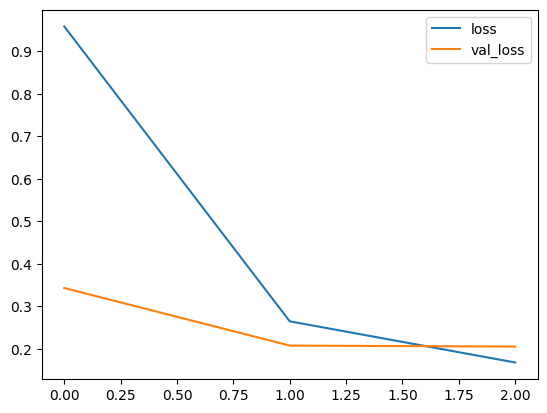

In [ ]:
loss, val_loss = train_history.history['loss'], train_history.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

Validation on the Test Set.

In [ ]:
predictions = bert_model.predict(X_test)
prediction_labels = predictions.argmax(axis=1)
print(classification_report(y_test, prediction_labels))
print(confusion_matrix(y_test, prediction_labels))
print(accuracy_score(y_test, prediction_labels))

63/63 [==============================] - 7s 110ms/step
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       275
           1       0.85      0.92      0.88       224
           2       0.92      0.95      0.94       695
           3       0.87      0.71      0.78       159
           4       0.96      0.94      0.95       581
           5       0.81      0.70      0.75        66

    accuracy                           0.92      2000
   macro avg       0.89      0.86      0.87      2000
weighted avg       0.92      0.92      0.91      2000

[[258   4   3   1   9   0]
 [ 10 205   0   0   6   3]
 [  3   5 662  14   4   7]
 [  1   0  45 113   0   0]
 [ 17   7   7   2 547   1]
 [  0  19   0   0   1  46]]
0.9155


# PART 4: Comparison with Real Life Data

## First Model: Fully connected NNN

Load the real case data

In [ ]:
df_r_train = pd.read_csv('./train.csv')
df_r_test = pd.read_csv('./test.csv')

In [ ]:
df_r_train.head()

,Unnamed: 0,article_title,is_ecology,processed
0,1079,Stations essence à Rochefort-en-Terre : les me...,0,station essence à rochefort - en - terre : les...
1,1515,"À Brest, le chantier de La Boussole se fait at...",0,"à brest , le chantier de la boussole se fait a..."
2,51,Météorite en Normandie : à la recherche de pré...,0,météorite en normandie : à la recherche de pré...
3,1419,Résultats trimestriels mitigés pour les géants...,0,résultats trimestriels mitigés pour les géants...
4,2181,Opinion | Sobriété énergétique : les solutions...,1,opinion | sobriété énergétique : les solution ...


Tokenize the data

In [ ]:
df_r_train['processed'] = df_r_train['article_title'].apply(preprocess_text)
df_r_test['processed'] = df_r_test['article_title'].apply(preprocess_text)

TFIDF transformation

In [ ]:
import nltk

nltk.download('stopwords')
final_stopwords_list = stopwords.words('english') + stopwords.words('french')

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=final_stopwords_list)

dtm_r_train = tfidf.fit_transform(df_r_train['processed'])
dtm_r_test = tfidf.transform(df_r_test['processed'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Setup the training and test data set

In [ ]:
X_r_train = dtm_r_train.toarray()
y_r_train = df_r_train['is_ecology']

X_r_test = dtm_r_test.toarray()
y_r_test = df_r_test['is_ecology']


Split the train and validation data set

In [ ]:
X_r_train.shape

(1772, 2446)

In [ ]:

X_r_train, X_r_val, y_r_train_encoded, y_r_val_encoded = train_test_split(X_r_train, y_r_train, test_size=0.2, random_state=42)

Build the model with same architecture, but change the last output layer as we have two categories in this case

In [ ]:
model = Sequential()
model.add(Dense(2048, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_r_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(1024, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(512, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model.add(Dense(256, activation='selu', kernel_initializer='lecun_normal', ))
# model.add(Dense(128, activation='selu', kernel_initializer='lecun_normal', ))
model.add(Dense(64, activation='selu', kernel_initializer='lecun_normal',))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam', loss=tf.losses.binary_crossentropy, metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 2048)              5011456   
                                                                 
 dense_27 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_28 (Dense)            (None, 512)               524800    
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 dense_30 (Dense)            (None, 64)                16448     
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 7,782,273
Trainable params: 7,782,273
No

Set up early stopping and dynamic learning rate

In [ ]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

lr_scheduler = LearningRateScheduler(step_decay)

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3) #

Train the model on new dataset.

In [ ]:
history_NN = model.fit(X_r_train, y_r_train_encoded, validation_data=(X_r_val, y_r_val_encoded), epochs=15, batch_size=16, callbacks=[early_stopping, lr_scheduler])

Epoch 1/15
111/111 [==============================] - 1s 12ms/step - loss: 0.5566 - accuracy: 0.9707 - val_loss: 0.2197 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 2/15
111/111 [==============================] - 1s 10ms/step - loss: 0.2163 - accuracy: 0.9797 - val_loss: 0.2129 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 3/15
111/111 [==============================] - 1s 10ms/step - loss: 0.2057 - accuracy: 0.9853 - val_loss: 0.1972 - val_accuracy: 0.9842 - lr: 0.0010
Epoch 4/15
111/111 [==============================] - 1s 9ms/step - loss: 0.1654 - accuracy: 0.9876 - val_loss: 0.1961 - val_accuracy: 0.9752 - lr: 0.0010
Epoch 5/15
111/111 [==============================] - 1s 9ms/step - loss: 0.1319 - accuracy: 0.9915 - val_loss: 0.1370 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 6/15
111/111 [==============================] - 1s 10ms/step - loss: 0.0925 - accuracy: 0.9949 - val_loss: 0.1338 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 7/15
111/111 [==============================] - 1s 11ms/step

Evaluation

In [ ]:
predictions_r = model.predict(X_r_test)
target_names = ['class 0', 'class 1']

predictions_r = (predictions_r > 0.5)*1
print(classification_report(y_r_test, predictions_r,target_names=target_names))
print(confusion_matrix(y_r_test, predictions_r))
print(accuracy_score(y_r_test, predictions_r))

10/10 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

     class 0       0.84      0.98      0.90       241
     class 1       0.62      0.15      0.24        53

    accuracy                           0.83       294
   macro avg       0.73      0.57      0.57       294
weighted avg       0.80      0.83      0.78       294

[[236   5]
 [ 45   8]]
0.8299319727891157


As you can see, we are having some trouble in recalling class 1, probably due to a very unbalanced dataset.

## LSTM Model

In [ ]:
#Adapting tokenization to French Dataset

tokenizer_lstm = Tokenizer() #(num_words = vocab_size, oov_token=oov_tok)
tokenizer_lstm.fit_on_texts(X_r_train)
word_index = tokenizer_lstm.word_index
sequences = tokenizer_lstm.texts_to_sequences(df_r_train['article_title'])
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer_lstm.texts_to_sequences(df_r_test['article_title'])
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

Building a new model for french dataset.

In [ ]:
vocab_size = len(tokenizer_lstm.word_index) + 1
embedding_dim = max_length


model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64)), #32
    Dropout(0.4),
    Dense(32, activation='leaky_relu', kernel_regularizer='l1_l2'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])


loss_function = 'binary_crossentropy'
optimizer = 'adam'

model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy', Precision(), Recall(), AUC()])

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          765500    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 32)                4128      
                                                                 
 dropout_41 (Dropout)        (None, 32)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 33        
                                                      

In [ ]:
y_r_train_encoded.shape, predictors.shape

((1772,), (2215, 100))

In [ ]:
predictors = np.array(padded)
epochs_value = 50
validation_split_value = 0.2
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
history = model.fit(predictors, df_r_train['is_ecology'], epochs=epochs_value, verbose=1, validation_split=validation_split_value, callbacks=[early_stopping])

Epoch 1/50
56/56 [==============================] - 8s 145ms/step - loss: 1.6726 - accuracy: 0.9786 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - auc_3: 0.4532 - val_loss: 1.0680 - val_accuracy: 0.9684 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.5000
Epoch 2/50
56/56 [==============================] - 4s 70ms/step - loss: 0.6632 - accuracy: 0.9786 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - auc_3: 0.6279 - val_loss: 0.3977 - val_accuracy: 0.9684 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.5000
Epoch 3/50
56/56 [==============================] - 3s 49ms/step - loss: 0.2638 - accuracy: 0.9786 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - auc_3: 0.5238 - val_loss: 0.2365 - val_accuracy: 0.9684 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_3: 0.5000
Epoch 4/50
56/56 [==============================] - 1s 19ms/step - loss: 0.2045 - accuracy: 0.9786 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - 

Plotting Losses.

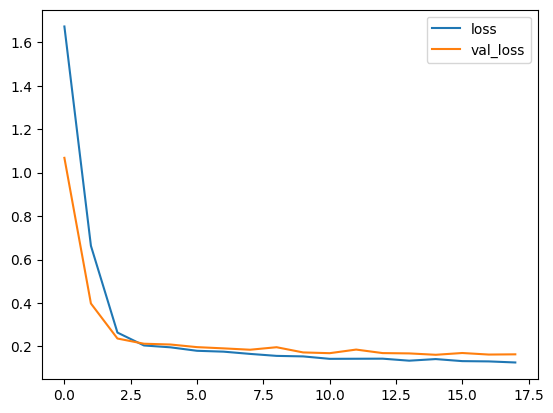

In [ ]:
loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

Printing Classification Report and Confusion Matrix

In [ ]:
predictions = model.predict(testing_padded)
predictions = (predictions > 0.5)*1
print(classification_report(df_r_test['is_ecology'].to_numpy(), predictions))
print(confusion_matrix(df_r_test['is_ecology'].to_numpy(), predictions))
print(accuracy_score(df_r_test['is_ecology'].to_numpy(), predictions))

10/10 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       241
           1       0.00      0.00      0.00        53

    accuracy                           0.82       294
   macro avg       0.41      0.50      0.45       294
weighted avg       0.67      0.82      0.74       294

[[241   0]
 [ 53   0]]
0.8197278911564626


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As you can see the result is not the best, the unbalanced dataset has really affected our results.

# Bert Model

In [ ]:
bert_X_train, bert_X_valid, bert_Y_train, bert_Y_valid = train_test_split(df_r_train['article_title'], df_r_train['is_ecology'],test_size=0.2,random_state=42,stratify=df_r_train['is_ecology'])

Encoding raw test for training validation and test.

In [ ]:
X_train = fast_encode(bert_X_train, fast_tokenizer, maxlen=max_length)
X_valid = fast_encode(bert_X_valid, fast_tokenizer, maxlen=max_length)
X_test = fast_encode(df_r_test['article_title'], fast_tokenizer, maxlen=max_length)

100%|██████████| 2/2 [00:00<00:00, 56.04it/s]


In [ ]:
X_train.shape

(1772, 100)

Encoding the labels.

Creating TensorFlow Datasets with our data.

In [ ]:

y_train_encoded = bert_Y_train
y_valid_encoded = bert_Y_valid
y_test_encoded = df_r_test['is_ecology']



BATCH_SIZE = 16

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)

)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_valid, y_valid_encoded))
    .batch(BATCH_SIZE)
    .cache()

)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_test,y_test_encoded))
    .batch(BATCH_SIZE)
)

Building the model.

In [ ]:
from tensorflow.keras.optimizers.experimental import Adam

def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)

    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

    return model

In [ ]:
transformer_layer = (
    transformers.TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
)


bert_model = build_model(transformer_layer, max_len=max_length)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
bert_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 100)]            0         
                                                                 
 tf_distil_bert_model_3 (TFD  TFBaseModelOutput(last_h  134734080
 istilBertModel)             idden_state=(None, 100,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem_3   (None, 768)              0         
 (SlicingOpLambda)                                               
                                                                 
 dense_35 (Dense)            (None, 1)                 769       
                                                           

Freezing all other layers

In [ ]:
bert_model.layers[0].trainable = False
bert_model.layers[1].trainable = False
bert_model.layers[2].trainable = False

Now that we have frozen the layers, we can see that the trainable params (thankfully) have reduced significantly.

In [ ]:
bert_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 100)]            0         
                                                                 
 tf_distil_bert_model_3 (TFD  TFBaseModelOutput(last_h  134734080
 istilBertModel)             idden_state=(None, 100,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem_3   (None, 768)              0         
 (SlicingOpLambda)                                               
                                                                 
 dense_35 (Dense)            (None, 1)                 769       
                                                           

Now we can train the data.

In [ ]:
n_steps = X_train.shape[0] // BATCH_SIZE
train_history = bert_model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=3
)

Epoch 1/3
110/110 [==============================] - 59s 276ms/step - loss: 0.1164 - accuracy: 0.9710 - precision_5: 0.0625 - recall_5: 0.0270 - auc_5: 0.5255 - val_loss: 0.1139 - val_accuracy: 0.9774 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_auc_5: 0.3711
Epoch 2/3
110/110 [==============================] - 24s 215ms/step - loss: 0.1231 - accuracy: 0.9744 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - auc_5: 0.5033 - val_loss: 0.1082 - val_accuracy: 0.9774 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_auc_5: 0.4251
Epoch 3/3
110/110 [==============================] - 22s 202ms/step - loss: 0.1198 - accuracy: 0.9750 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - auc_5: 0.5199 - val_loss: 0.1093 - val_accuracy: 0.9774 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_auc_5: 0.4326


Plotting Losses

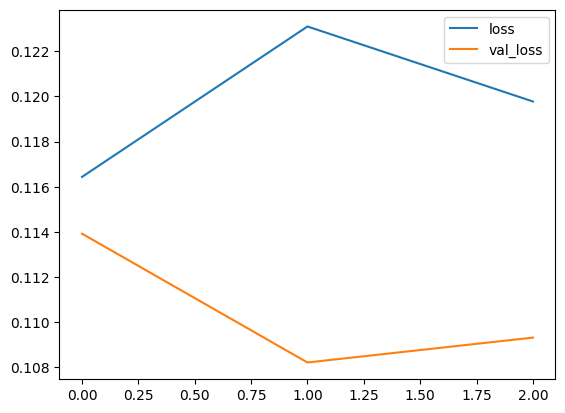

In [ ]:
loss, val_loss = train_history.history['loss'], train_history.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

As you can see the results are terrible due to the unbalanced dataset.

In [ ]:
predictions = bert_model.predict(X_test)
prediction_labels = (predictions > 0.5)*1
print(classification_report(df_r_test['is_ecology'], prediction_labels))
print(confusion_matrix(df_r_test['is_ecology'], prediction_labels))
print(accuracy_score(df_r_test['is_ecology'], prediction_labels))

10/10 [==============================] - 1s 109ms/step
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       241
           1       0.00      0.00      0.00        53

    accuracy                           0.82       294
   macro avg       0.41      0.50      0.45       294
weighted avg       0.67      0.82      0.74       294

[[241   0]
 [ 53   0]]
0.8197278911564626


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusion in Real Life Dataset

Surprisingly the most successful model was the Fully Connected Neural Network. This is because it did not have 0 recall in the target class.

